In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import admix
import dask
import dask.array as da
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from admix.data import quantile_normalize
import submitit
import dapgen
import os
import admix_genet_cor

In [2]:
PAGE_GENO_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr/imputed/"
PAGE_PHENO_DIR = "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/03-page-genome-wide-profile-likelihood-new/out/pheno"

UKB_GENO_DIR = "/u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed"
UKB_PHENO_DIR = "/u/project/sgss/UKBB/UKB-ADMIXED/02-genet-cor/out/pheno/"

DATA_DIR = "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/05-real-locus"

In [3]:
df_info = pd.DataFrame(
    [
        ["ukb", "erythrocyte", 16, 357598],
        ["page", "crp", 1, 159638387],
        ["page", "hdl", 11, 116810245],
        ["ukb", "log_triglycerides", 19, 35065736],
        ["ukb", "MCH", 16, 1121191],
    ],
    columns=["study", "trait", "chrom", "pos"],
)

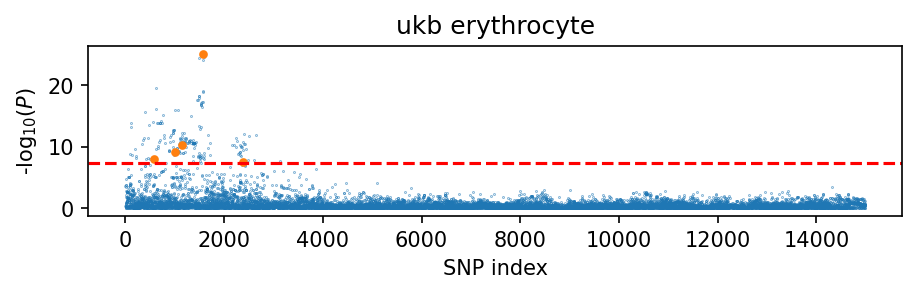

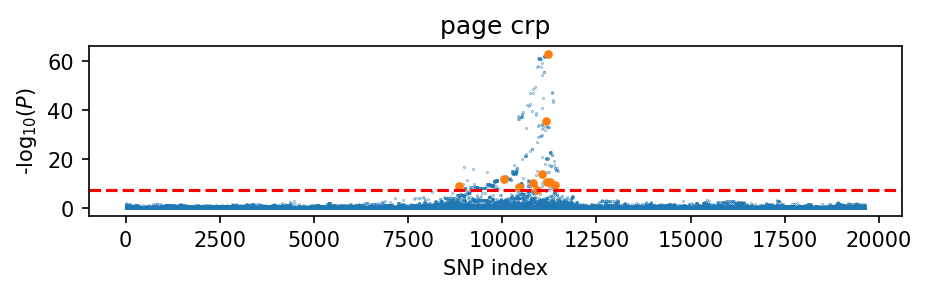

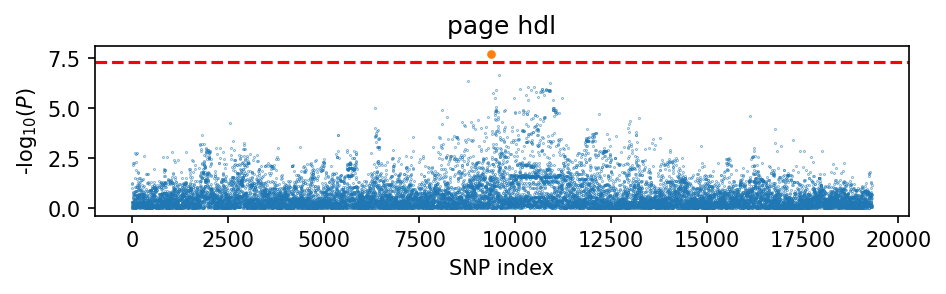

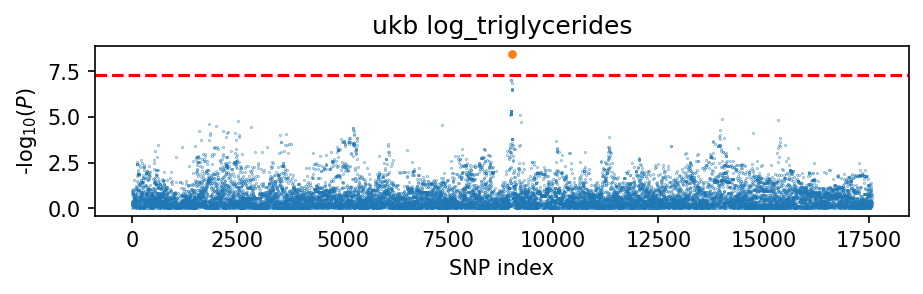

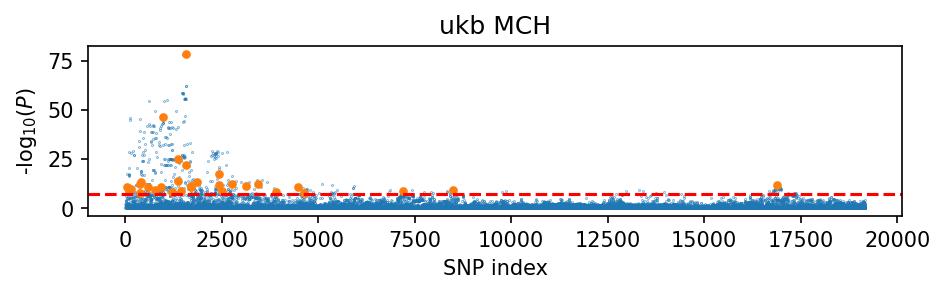

In [4]:
for _, row in df_info.iterrows():
    study, trait, chrom, pos = row

    # read association
    df_assoc = pd.read_csv(
        os.path.join(DATA_DIR, f"out/gwas-assoc/{study}-{trait}.assoc"),
        delim_whitespace=True,
    )
    df_assoc = df_assoc[
        (df_assoc["#CHROM"] == chrom)
        & (df_assoc["POS"].between(pos - 1.5e6, pos + 1.5e6))
    ]

    # read clumping
    df_clump = (
        pd.read_csv(
            os.path.join(DATA_DIR, f"out/gwas-assoc/{study}-{trait}.clumped"), sep="\t"
        )[["CHR", "SNP", "BP", "P"]]
        .rename(columns={"CHR": "CHROM", "SNP": "SNP", "BP": "POS", "P": "PLINK_P"})
        .set_index("SNP")
    )
    df_clump = df_clump[df_clump.CHROM == chrom]
    clump_mask = df_assoc.ID.isin(df_clump.index).values

    # plotting
    fig, ax = plt.subplots(figsize=(7, 1.5), dpi=150)
    admix.plot.manhattan(df_assoc["P"], s=0.05)
    ax.scatter(
        np.arange(len(df_assoc))[clump_mask],
        -np.log10(df_assoc["P"])[clump_mask],
        s=10,
        label="Clumped SNPs",
    )
    ax.set_title(f"{study} {trait}")

# save data for finemapping analysis

In [5]:
for _, row in df_info.iterrows():
    study, trait, chrom, pos = row

    # load both phenotype and covariates
    geno_dir = UKB_GENO_DIR if study == "ukb" else PAGE_GENO_DIR
    pheno_dir = UKB_PHENO_DIR if study == "ukb" else PAGE_PHENO_DIR

    pheno_path = os.path.join(pheno_dir, f"{trait}-sample10pc.tsv")
    df_pheno = pd.read_csv(pheno_path, sep="\t", index_col=0, low_memory=False)

    dset = admix.io.read_dataset(
        os.path.join(geno_dir, f"chr{chrom}"),
        n_anc=2,
    )
    dset = dset[
        dset.snp.POS.between(pos - 1.5e6, pos + 1.5e6).values,
        dset.indiv.index.isin(df_pheno.index.values),
    ]
    if study == "ukb":
        dset._indiv.drop(columns=["SEX"], inplace=True)
    out_dir = os.path.join(
        DATA_DIR, f"out/hetero-example/{study}-{trait}-{chrom}-{pos}"
    )
    os.makedirs(out_dir, exist_ok=True)

    df_pheno = df_pheno.reindex(dset.indiv.index.values)
    assert np.all(dset.indiv.index == df_pheno.index)

    df_pheno.to_csv(os.path.join(out_dir, "pheno.raw.tsv"), sep="\t", index=True)

    # convert dummy variable & perform quantile normalization

    df_pheno = admix.data.convert_dummy(df_pheno)

    for col in df_pheno.columns:
        df_pheno[col] = admix.data.quantile_normalize(df_pheno[col])
    df_pheno.to_csv(os.path.join(out_dir, "pheno.tsv"), sep="\t", index=True)

    # save genotype
    admix.io.write_dataset(
        geno=dset.geno,
        lanc=admix.data.Lanc(array=dset.lanc),
        df_indiv=dset.indiv,
        df_snp=dset.snp,
        out_prefix=os.path.join(out_dir, "plink2"),
    )

2022-03-27 09:46.22 [info     ] admix.Dataset: read local ancestry from /u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed/chr16.lanc
2022-03-27 09:46.26 [info     ] Detected categorical columns: 
2022-03-27 09:46.26 [info     ] Added dummy variables: 
2022-03-27 09:46.45 [info     ] admix.Dataset: read local ancestry from /u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr/imputed/chr1.lanc
2022-03-27 09:46.53 [info     ] Detected categorical columns: study
2022-03-27 09:46.53 [info     ] Added dummy variables: study_MEC,study_WHI


/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/dask/array/routines.py:2044: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  ind = stack([ind[i].ravel() for i in range(len(ind))], axis=1)


2022-03-27 09:48.10 [info     ] admix.Dataset: read local ancestry from /u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr/imputed/chr11.lanc
2022-03-27 09:48.14 [info     ] Detected categorical columns: study
2022-03-27 09:48.14 [info     ] Added dummy variables: study_MEC,study_WHI


/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/dask/array/routines.py:2044: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  ind = stack([ind[i].ravel() for i in range(len(ind))], axis=1)


2022-03-27 09:49.33 [info     ] admix.Dataset: read local ancestry from /u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed/chr19.lanc
2022-03-27 09:49.35 [info     ] Detected categorical columns: 
2022-03-27 09:49.35 [info     ] Added dummy variables: 
2022-03-27 09:49.57 [info     ] admix.Dataset: read local ancestry from /u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed/chr16.lanc
2022-03-27 09:50.00 [info     ] Detected categorical columns: 
2022-03-27 09:50.00 [info     ] Added dummy variables: 


# An example analysis

In [6]:
# Causal variants likely correspond to a variant with highly differentiated SNP across ancestries
out_dir = os.path.join(DATA_DIR, "out/hetero-example/ukb-log_triglycerides-19-35065736")

In [7]:
dset = admix.io.read_dataset(os.path.join(out_dir, "plink2"))
df_pheno = pd.read_csv(os.path.join(out_dir, "pheno.tsv"), sep="\t", index_col=0)
df_pheno = admix.data.convert_dummy(df_pheno)

2022-03-27 09:50.23 [info     ] admix.Dataset: read local ancestry from /u/project/pasaniuc/kangchen/2021-admix-corr/experiments/05-real-locus/out/hetero-example/ukb-log_triglycerides-19-35065736/plink2.lanc
2022-03-27 09:50.23 [info     ] admix.Dataset: infered n_anc=2. If not correct, provide `n_anc` when constructing admix.Dataset.
2022-03-27 09:50.23 [info     ] Detected categorical columns: 
2022-03-27 09:50.23 [info     ] Added dummy variables: 


2022-03-27 09:50.23 [info     ] NaN found in covariates, impute with column mean for each covariate.


admix.assoc.marginal: 100%|██████████| 18/18 [01:30<00:00,  5.03s/it]

2022-03-27 09:51.54 [info     ] NaN found in covariates, impute with column mean for each covariate.



admix.assoc.marginal: 100%|██████████| 18/18 [02:20<00:00,  7.78s/it]

2022-03-27 09:54.14 [info     ] NaN found in covariates, impute with column mean for each covariate.



admix.assoc.marginal: 100%|██████████| 18/18 [02:29<00:00,  8.30s/it]


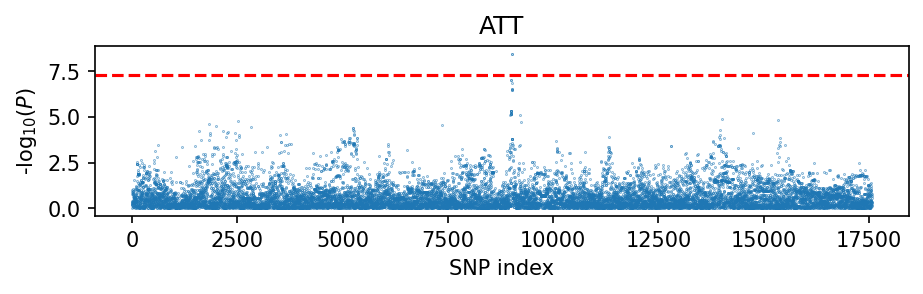

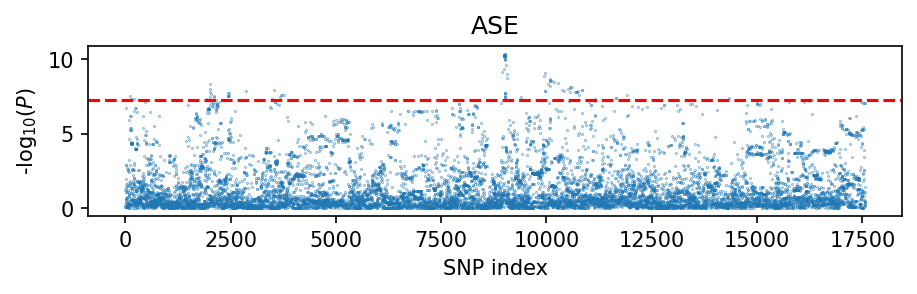

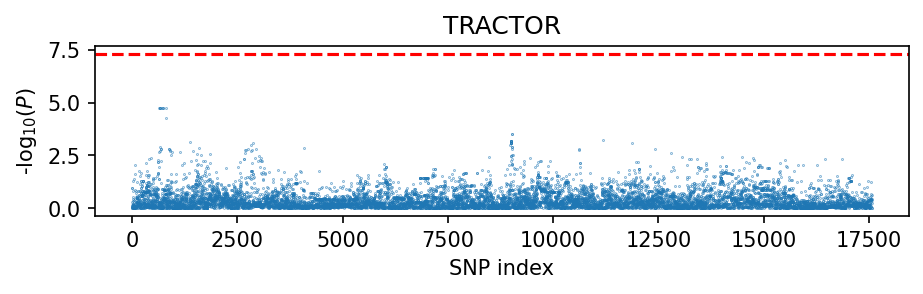

In [8]:
for method in ["ATT", "ASE", "TRACTOR"]:
    df_assoc = admix.assoc.marginal(
        dset, pheno=df_pheno["PHENO"].values, cov=df_pheno.iloc[:, 1:], method=method
    )
    fig, ax = plt.subplots(figsize=(7, 1.5), dpi=150)
    admix.plot.manhattan(df_assoc["P"], s=0.05)
    ax.set_title(method)
    fig.show()

In [9]:
# apa = dset.allele_per_anc()
# af = dset.af_per_anc()

# df_trait = df_pheno.iloc[:, [0]]
# df_covar = df_pheno.iloc[:, 1:]
# df_covar.fillna(df_covar.mean(), inplace=True)

# for snp_i in tqdm(range(dset.n_snp)):
#     p_het, model_het = admix_genet_cor.test_snp_het(
#         apa[snp_i, :, :], df_trait.values, df_covar.values
#     )
#     p_assoc, model_assoc = admix_genet_cor.test_snp_assoc(
#         apa[snp_i, :, :], df_trait.values, df_covar.values
#     )
#     print(p_het, p_assoc)

In [10]:
# apa = dset.allele_per_anc()
# af = dset.af_per_anc()

# df_trait = df_pheno.iloc[:, [0]]
# df_covar = df_pheno.iloc[:, 1:]
# df_covar.fillna(df_covar.mean(), inplace=True)

# for snp_i in tqdm(range(dset.n_snp)):
#     p_het, model_het = admix_genet_cor.test_snp_het(
#         apa[snp_i, :, :], df_trait.values, df_covar.values
#     )
#     p_assoc, model_assoc = admix_genet_cor.test_snp_assoc(
#         apa[snp_i, :, :], df_trait.values, df_covar.values
#     )
#     print(p_het, p_assoc)

In [11]:
# def submit_locus_hetero(study, trait, out):

#     # load clumped variants
#     clump_file = f"out/gwas-assoc/{study}-{trait}.clumped"
#     if sum(1 for line in open(clump_file)) == 1:
#         with open(out, "w") as f:
#             f.writelines("# No clumped region")
#         return

#     df_assoc = (
#         pd.read_csv(f"out/gwas-assoc/{study}-{trait}.clumped", sep="\t")[
#             ["CHR", "SNP", "BP", "P"]
#         ]
#         .rename(columns={"CHR": "CHROM", "SNP": "SNP", "BP": "POS", "P": "PLINK_P"})
#         .set_index("SNP")
#     )

#     # load both phenotype and covariates
#     geno_dir = UKB_GENO_DIR if study == "ukb" else PAGE_GENO_DIR
#     pheno_dir = UKB_PHENO_DIR if study == "ukb" else PAGE_PHENO_DIR

#     pheno_path = os.path.join(pheno_dir, f"{trait}-sample10pc.tsv")
#     df_sample_info = pd.read_csv(pheno_path, sep="\t", index_col=0, low_memory=False)

#     pheno_col = df_sample_info.columns[0]
#     covar_cols = df_sample_info.columns[1:]

#     # format phenotype and covariates
#     df_trait = pd.read_csv(pheno_path, sep="\t", index_col=0)
#     df_trait.index = df_trait.index.astype(str)

#     dset = admix.io.read_dataset(
#         os.path.join(geno_dir, "chr1"),
#         n_anc=2,
#     )
#     for col in dset._indiv:
#         dset._indiv.drop(columns=col, inplace=True)

#     # subset for individuals with non-nan value in df_trait
#     dset = dset[:, dset.indiv.index.isin(df_trait.index)]
#     dset.append_indiv_info(df_trait)
#     pheno_col = df_trait.columns[[0]]
#     covar_cols = df_trait.columns[1:]

#     df_pheno = dset.indiv[pheno_col].copy()
#     df_covar = dset.indiv[covar_cols].copy()
#     df_covar = admix.data.convert_dummy(df_covar)

#     for col in df_pheno.columns:
#         df_pheno[col] = admix.data.quantile_normalize(df_pheno[col])

#     for col in df_covar.columns:
#         df_covar[col] = admix.data.quantile_normalize(df_covar[col])

#     # fill na with column mean
#     df_covar.fillna(df_covar.mean(), inplace=True)

#     for chrom in range(1, 23):
#         # subset df_assoc
#         df_assoc_chrom = df_assoc[df_assoc.CHROM == chrom]
#         if len(df_assoc_chrom) == 0:
#             continue
#         # subset dset
#         dset = admix.io.read_dataset(
#             os.path.join(geno_dir, f"chr{chrom}"),
#             n_anc=2,
#         )
#         dset = dset[df_assoc_chrom.index.values, df_pheno.index.values]
#         dset.persist()

#         apa = dset.allele_per_anc()
#         af = dset.af_per_anc()

#         for snp_i in tqdm(range(dset.n_snp)):
#             p_het, model_het = admix_genet_cor.test_snp_het(
#                 apa[snp_i, :, :], df_pheno.values, df_covar.values
#             )
#             p_assoc, model_assoc = admix_genet_cor.test_snp_assoc(
#                 apa[snp_i, :, :], df_pheno.values, df_covar.values
#             )
#             snp_idx = dset.snp.index[snp_i]
#             df_assoc.loc[snp_idx, ["EUR_af", "AFR_af"]] = (
#                 af[snp_i, 0],
#                 af[snp_i, 1],
#             )

#             df_assoc.loc[
#                 snp_idx,
#                 [
#                     "assoc_pval",
#                     "HET_pval",
#                     "EUR_beta",
#                     "AFR_beta",
#                     "EUR_beta_stderr",
#                     "AFR_beta_stderr",
#                 ],
#             ] = [
#                 p_assoc,
#                 p_het,
#                 model_het.params[1],
#                 model_het.params[2],
#                 model_het.bse[1],
#                 model_het.bse[2],
#             ]
#     df_assoc[["CHROM", "POS"]] = df_assoc[["CHROM", "POS"]].astype(int)
#     df_assoc.sort_values(["CHROM", "POS"]).to_csv(out, float_format="%.8g")